!pip install pandas matplotlib

# LR transfer

In [19]:
import pandas as pd
from matplotlib import pyplot as plt

In [20]:
#df = pd.read_csv('adam25.csv')
df = pd.read_csv('adam50.csv')
df = pd.read_csv('adam25.csv')

# remove rows with hidden_size in 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000
df = df[~df['hidden_size'].isin([500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])]

In [21]:
(df['lr'] == 10).sum()

np.int64(0)

In [22]:
def lr_curve(df, field, use_mup=None, minimize=True):
    # increase plot font size
    plt.rcParams.update({'font.size': 16})
    df2 = df.groupby(['hidden_size', 'use_mup'])
    for name, group in df2:
        if name[1]:
            if use_mup is not None and not use_mup:
                continue
            label = f'mup {name[0]}'
        else:
            if use_mup is not None and use_mup:
                continue
            label = f'std {name[0]}'
        group = group.sort_values('lr')
        if minimize:
            print(f"{name[0]}: {group['lr'].iloc[group[field].argmin().item()]}")
        else:
            print(f"{name[0]}: {group['lr'].iloc[group[field].argmax().item()]}")
        #print(group['lr'].iloc[-1])
        #print(group[field].iloc[-1])
        #print(len(group['lr']))
        #print(len(group[field]))
        plt.semilogx(group['lr'], group[field], label=label, marker='x', linestyle=':')
    plt.xlabel('lr')
    plt.ylabel(field)
    plt.legend()
    plt.show()

512: 0.25
1024: 0.125
2048: 0.25
4096: 0.25
9192: 0.125


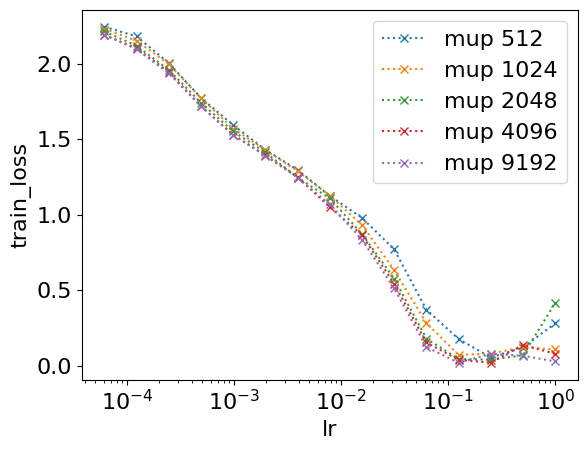

512: 0.01563
1024: 0.01563
2048: 0.01563
4096: 0.03125
9192: 0.03125


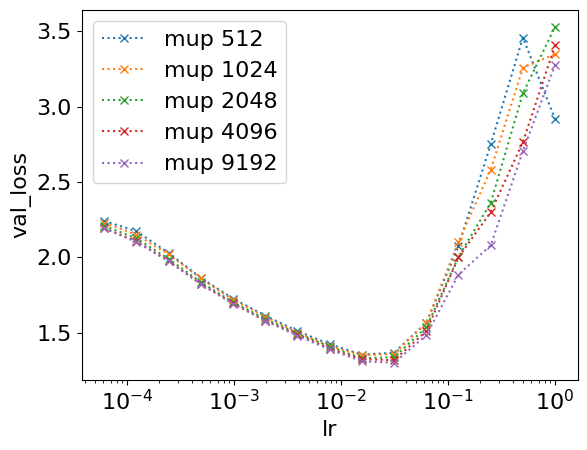

512: 0.25
1024: 0.125
2048: 0.125
4096: 0.0625
9192: 0.125


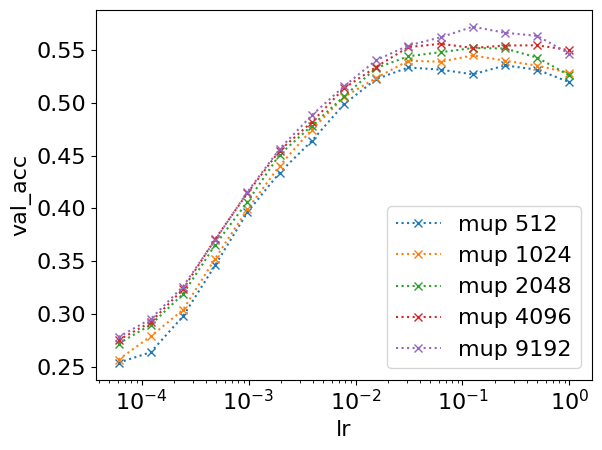

In [23]:
lr_curve(df, 'train_loss', use_mup=True)
lr_curve(df, 'val_loss', use_mup=True)
lr_curve(df, 'val_acc', use_mup=True, minimize=False)

512: 0.0004883
1024: 0.0009766
2048: 0.0004883
4096: 0.000122
9192: 0.0002441


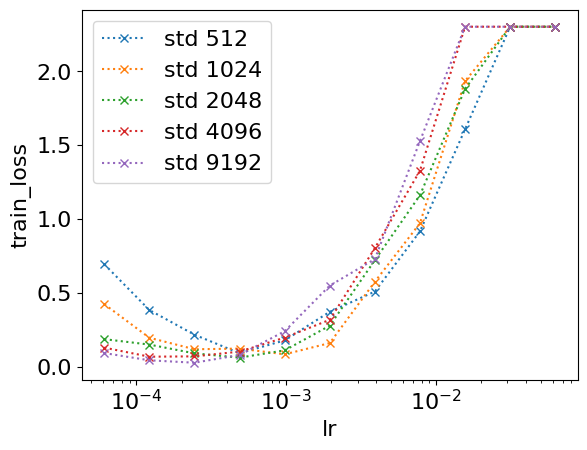

512: 6.103e-05
1024: 6.103e-05
2048: 6.103e-05
4096: 0.007813
9192: 0.003906


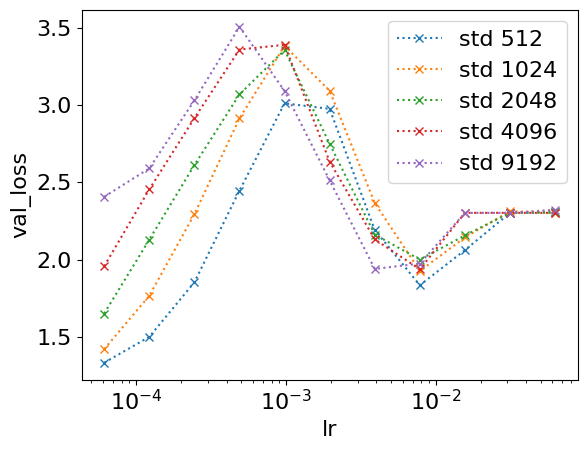

512: 0.0004883
1024: 0.0002441
2048: 0.000122
4096: 0.000122
9192: 0.000122


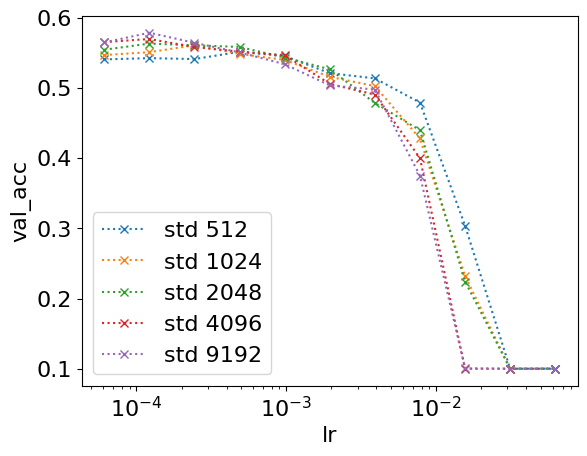

In [24]:
lr_curve(df, 'train_loss', use_mup=False)
lr_curve(df, 'val_loss', use_mup=False)
lr_curve(df, 'val_acc', use_mup=False, minimize=False)

# Coordinate check

!pip install wandb

!wandb login a3f45dd6719a8619b0c46df881e5470cacb08ba2

In [25]:
# let's fetch some data about the runs from wandb
import wandb
api = wandb.Api()
runs_all = api.runs("chrisxx/cifar10-adam")
runs = []
for run in runs_all:
    if 'hidden_size' not in run.config:
        continue
    runs.append(run)
    print(run.name, run.config['hidden_size'], run.config['use_mup'], run.config['lr'], run.summary['val_acc'])
    

std_adam_w1024_lr0.001_e10_b128_9921 1024 False 0.001 0.557200014591217
mup_adam_w1024_lr0.001_e10_b128_4759 1024 True 0.001 0.3425999879837036
std_adam_w2048_lr0.001_e10_b128_3107 2048 False 0.001 0.5386999845504761
mup_adam_w2048_lr0.001_e10_b128_3584 2048 True 0.001 0.3465999960899353
std_adam_w1024_lr6.103e-05_e25_b128_8427 1024 False 6.103e-05 0.5467000007629395
mup_adam_w1024_lr6.103e-05_e25_b128_5135 1024 True 6.103e-05 0.2567000091075897
std_adam_w1024_lr0.000122_e25_b128_3160 1024 False 0.000122 0.5508000254631042
mup_adam_w1024_lr0.000122_e25_b128_2875 1024 True 0.000122 0.27869999408721924
std_adam_w1024_lr0.0002441_e25_b128_6527 1024 False 0.0002441 0.560699999332428
mup_adam_w1024_lr0.0002441_e25_b128_6283 1024 True 0.0002441 0.30379998683929443
std_adam_w1024_lr0.0004883_e25_b128_2101 1024 False 0.0004883 0.54830002784729
mup_adam_w1024_lr0.0004883_e25_b128_5155 1024 True 0.0004883 0.352400004863739
std_adam_w1024_lr0.0009766_e25_b128_5107 1024 False 0.0009766 0.539799988

In [26]:
# get train loss curve of a run
n_epochs = 25
lr = None
hidden_sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
mup_width_df = {}
std_width_df = {}
mup_width_summary = {}
std_width_summary = {}

for run in runs:
    if lr is not None and run.config['lr'] != lr:
        continue
    if hidden_sizes is not None and run.config['hidden_size'] not in hidden_sizes:
        continue
    if run.config['use_mup']:
        mup_width_df[run.config['hidden_size']] = run.history()
        mup_width_summary[run.config['hidden_size']] = run.summary
    else:
        std_width_df[run.config['hidden_size']] = run.history()
        std_width_summary[run.config['hidden_size']] = run.summary

#run = runs[0]
#df = run.history()
#plt.plot(df['train_loss'])



In [27]:
mup_width_df[500].columns

Index(['_runtime', 'act change h1', 'grad norm fc2.weight',
       'grad norm fc3.weight', 'act norm h1', 'act mean(abs(a2))',
       'grad mean(abs(grad_fc1.weight))', 'epoch', 'act change a1',
       'spectral_norm_W0', 'grad mean(abs(grad_fc2.weight))', 'act norm a2',
       'act change a3', 'grad mean(abs(grad_fc3.weight))', 'act mean(abs(a1))',
       'spectral_norm_W1', 'act norm h2', 'trainer/global_step',
       'act change a2', 'act mean(abs(h1))', 'test_loss', 'act norm a1',
       'val_loss', 'val_acc', 'act mean(abs(h2))', '_timestamp', 'train_loss',
       'act change h2', 'test_acc', 'act mean(abs(a3))',
       'grad norm fc1.weight', 'spectral_norm_W2', '_step', 'act norm a3'],
      dtype='object')

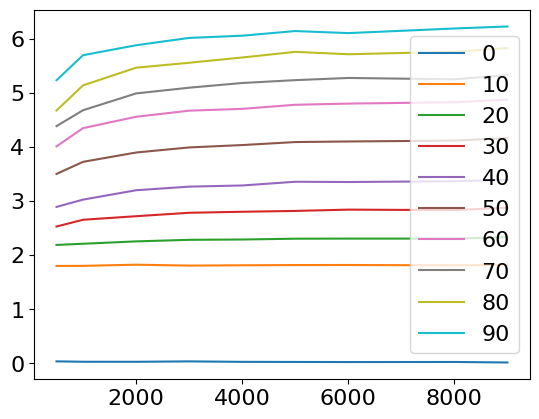

In [40]:
import numpy as np
data = []
widths = sorted(list(mup_width_df.keys()))
for w in widths:
    d = mup_width_df[w]['act mean(abs(a3))'].to_numpy()[np.newaxis]
    #print(d.shape)
    data += [d[:, :100]]
data = np.concatenate(data, axis=0)
for i in range(10):
    plt.plot(widths, data.T[i*10], label=f'{i*10}')
plt.legend()
plt.show()

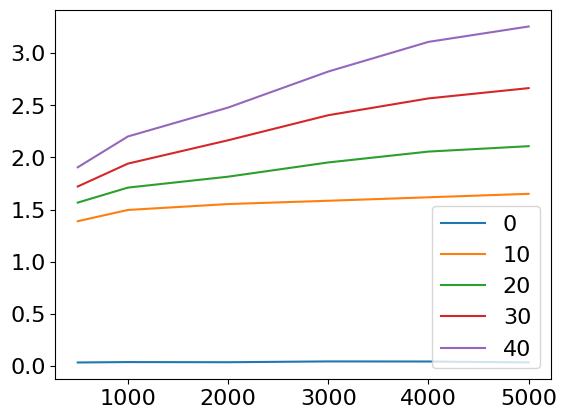

In [39]:
data = []
widths = sorted(list(std_width_df.keys()))
for w in widths:
    d = std_width_df[w]['act mean(abs(a3))'].to_numpy()[np.newaxis]
    data += [d[:, :50]]
data = np.concatenate(data, axis=0)
for i in range(5):
    plt.plot(widths, data.T[i*10], label=f'{i*10}')
plt.legend()
plt.show()

# spectral norm and activation change

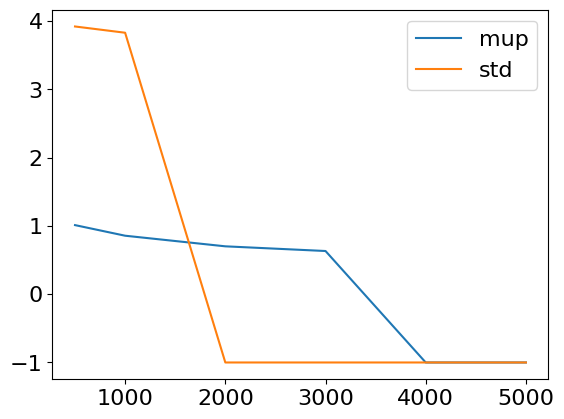

In [35]:
mup_data = []
std_data = []
key = 'spectral_norm_W0'
#key = 'act_change_a3'
for w in widths:
    if key in mup_width_summary[w]:
        mup_data += [mup_width_summary[w][key]]
    else:
        mup_data += [-1]
    
    if key in std_width_summary[w]:
        std_data += [std_width_summary[w][key]]
    else:
        std_data += [-1]


plt.plot(widths, mup_data, label='mup')
plt.plot(widths, std_data, label='std')
plt.legend()
plt.show()